# Designing Convolution Network Architectures

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
class AnyNet(d2l.Classifier):
    def stem(self, num_channels):
        return nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU())

In [3]:
@d2l.add_to_class(AnyNet)
def stage(self, depth, num_channels, groups, bot_mul):
    blk = []
    for i in range(depth):
        if i == 0:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul,
                use_1x1conv=True, strides=2))
        else:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul))
    return nn.Sequential(*blk)

In [4]:
@d2l.add_to_class(AnyNet)
def __init__(self, arch, stem_channels, lr=0.1, num_classes=10):
    super(AnyNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.stem(stem_channels))
    for i, s in enumerate(arch):
        self.net.add_module(f'stage{i+1}', self.stage(*s))
    self.net.add_module('head', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [5]:
class RegNetX32(AnyNet):
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 1
        depths, channels = (4, 6), (32, 80)
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),
             (depths[1], channels[1], groups, bot_mul)),
            stem_channels, lr, num_classes)

In [6]:
RegNetX32().layer_summary((1, 1, 96, 96))

/usr/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 32, 48, 48])
Sequential output shape:	 torch.Size([1, 32, 24, 24])
Sequential output shape:	 torch.Size([1, 80, 12, 12])
Sequential output shape:	 torch.Size([1, 10])


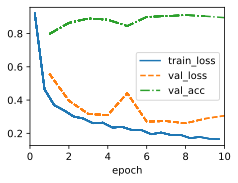

In [7]:
model = RegNetX32(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

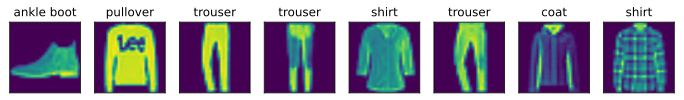

In [61]:
batch = next(iter(data.get_dataloader(train=False)))
data.visualize(batch)

In [23]:
batch[0].shape, batch[1].shape

(torch.Size([128, 1, 96, 96]), torch.Size([128]))

In [49]:
model.loss(model(batch[0].to('cuda')), batch[1].to('cuda'))

tensor(0.2794, device='cuda:0', grad_fn=<NllLossBackward0>)

In [50]:
model.accuracy(model(batch[0].to('cuda')), batch[1].to('cuda'))

tensor(0.8828, device='cuda:0')

In [51]:
model.accuracy(model(batch[0].to('cuda')), batch[1].to('cuda'), averaged=False)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
        1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:0')

In [55]:
acc_list = [model.accuracy(model(batch[0].to('cuda')), batch[1].to('cuda')) for batch in data.get_dataloader(train=False)]

In [59]:
torch.tensor(acc_list).mean()

tensor(0.8954)

In [71]:
def accuracy(model, data):
    return torch.tensor(
        [model.accuracy(model(batch[0].to('cuda')), batch[1].to('cuda')) for batch in data.get_dataloader(train=False)]
    ).mean()

In [72]:
accuracy(model, data)

tensor(0.8954)

## 练习

1. Increase the number of stages to four. Can you design a deeper RegNetX that performs better?

In [73]:
class RegNetX86(AnyNet):
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 1
        depths, channels = (4, 6, 8, 10), (32, 80, 128, 192)
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),
             (depths[1], channels[1], groups, bot_mul)),
            stem_channels, lr, num_classes)

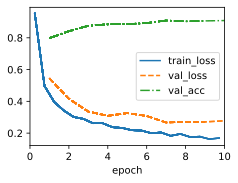

In [75]:
model = RegNetX86(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

In [76]:
accuracy(model, data)

tensor(0.9084)

In [77]:
class RegNetX98(AnyNet):
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 0.5
        depths, channels = (4, 8, 16, 4), (64, 128, 256, 512)
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),
             (depths[1], channels[1], groups, bot_mul)),
            stem_channels, lr, num_classes)

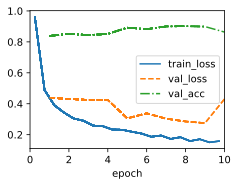

In [78]:
model = RegNetX98(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

In [79]:
accuracy(model, data)

tensor(0.8636)

In [80]:
class RegNetX182(AnyNet):
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 0.5
        depths, channels = (4, 8, 16, 32), (64, 128, 256, 512)
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),
             (depths[1], channels[1], groups, bot_mul)),
            stem_channels, lr, num_classes)

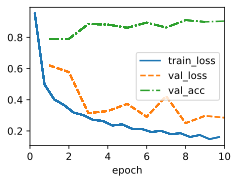

In [81]:
model = RegNetX182(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

In [82]:
accuracy(model, data)

tensor(0.9043)

In [83]:
class RegNetX86b(AnyNet):
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 0.5
        depths, channels = (4, 6, 8, 10), (64, 128, 256, 512)
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),
             (depths[1], channels[1], groups, bot_mul)),
            stem_channels, lr, num_classes)

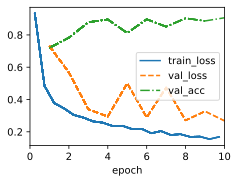

In [84]:
model = RegNetX86b(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

In [85]:
accuracy(model, data)

tensor(0.9063)

2. De-ResNeXt-ify RegNets by replacing the ResNeXt block with the ResNet block. How does your new model perform?

In [86]:
class RegNetX86c(AnyNet):
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels = 32
        depths, channels = (4, 6, 8, 10), (32, 80, 128, 192)
        super().__init__(
            ((depths[0], channels[0]),
             (depths[1], channels[1])),
            stem_channels, lr, num_classes)
    
    def stage(self, depth, num_channels):
        blk = []
        for i in range(depth):
            if i == 0:
                blk.append(d2l.Residual(num_channels,
                    use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(num_channels))
        return nn.Sequential(*blk)

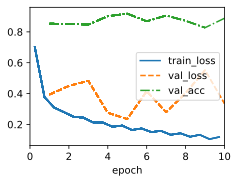

In [87]:
model = RegNetX86c(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

In [88]:
accuracy(model, data)

tensor(0.8879)